# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [1]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import linear_model

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
from hurst import compute_Hc, random_walk
import nolds
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [65]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

filelist = ['dummy5_full.csv']#,'dummy2_full.csv']#,'dummy3_full.csv','dummy5_full.csv',
           # 'dummybbvs_1.csv', 'dummybbvs_2.csv']

def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        d[idx].get_METS()
        d[idx].get_HRV()
        d[idx].get_PA()
        d[idx].get_sleep(q_sleep=0.4, bed_time = '20:00',wake_time = '12:00', seq_length = 15)
        #d[idx].get_SRI(q_sleep=0.4)
        d[idx].get_cosinor()
        d[idx].get_SSA()
        #d[idx].get_nonlinear()
    return d

d = get_data(filelist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Sanity check plot - see if data extraction worked for METmins and sleep windows 

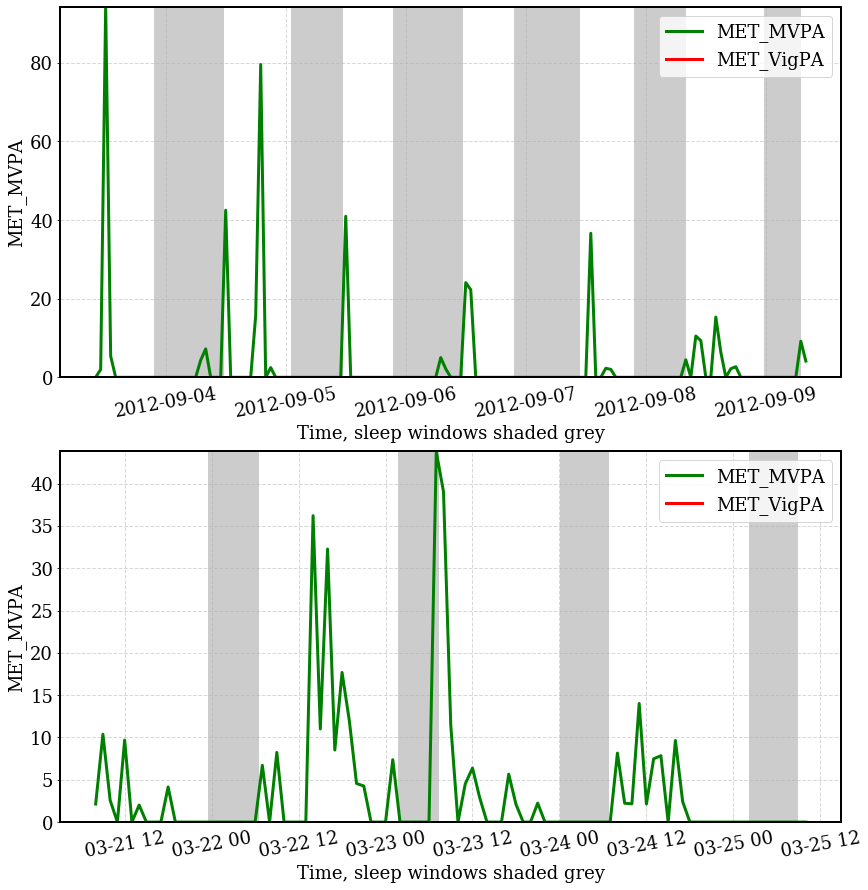

In [4]:
from population_plots import plot_basic
        
plot_basic(d)

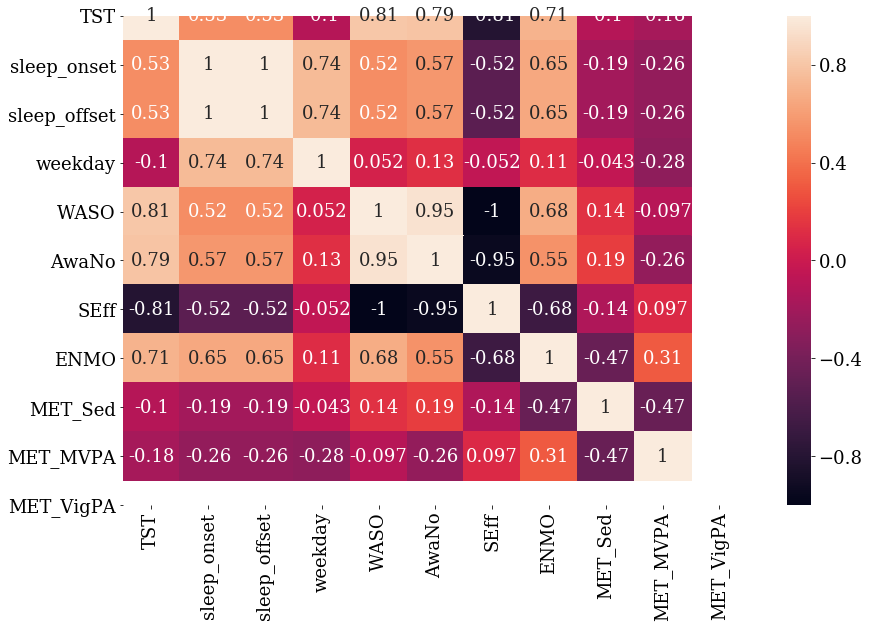

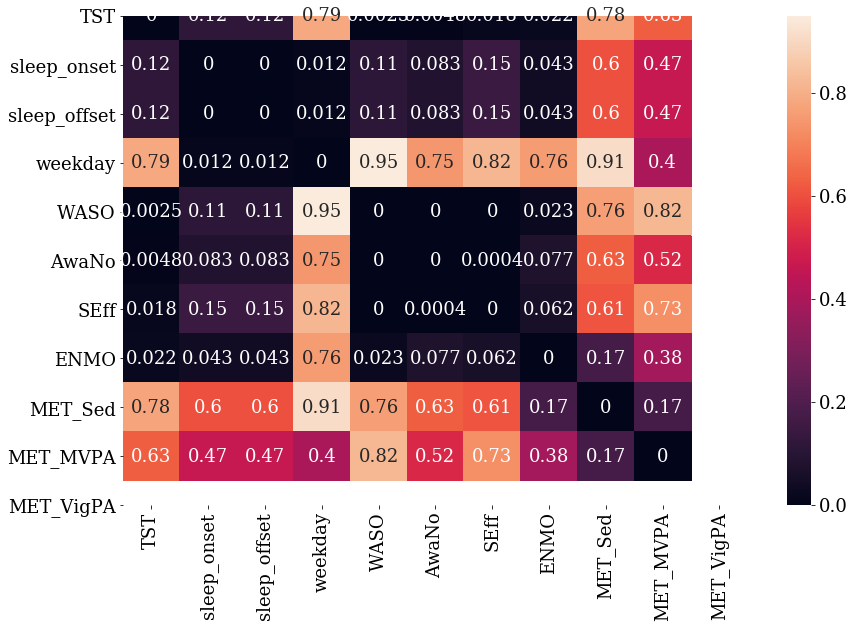

In [5]:
from population_stats import get_ranks

ranks,ranks_agg,ranks_agg_p = get_ranks(d,shift=0)

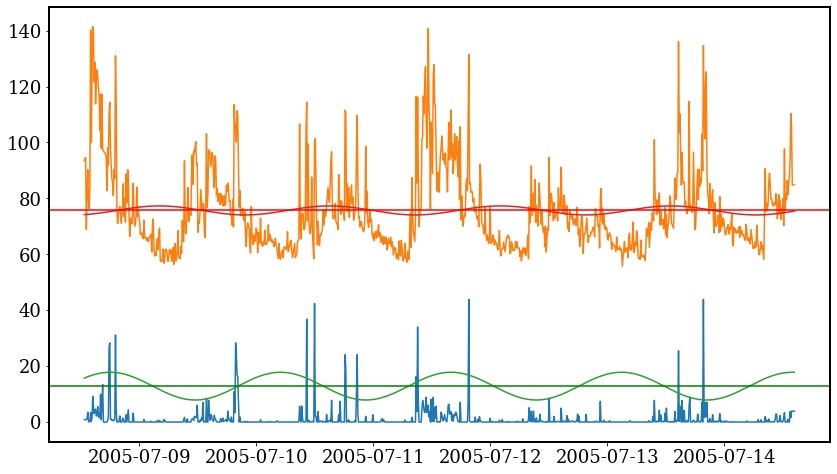

In [31]:
length = 998
timeSpan = (d[0].data.index[-1]-d[0].data.index[0]+timedelta(minutes=1))
rule = int(timeSpan.total_seconds()/length)
tsNew=d[0].data.resample(str(rule)+"S", fill_method='pad',closed='right')


#pd.DataFrame(d[0].cosinor['ENMO'][4]).plot()
plt.plot(tsNew.index,tsNew['ENMO']/10)
plt.plot(tsNew.index,tsNew['mean_hr'])
plt.plot(tsNew.index,d[0].cosinor['ENMO'][4])
plt.plot(tsNew.index,d[0].cosinor['mean_hr'][4])
plt.axhline(y=d[0].cosinor['mesor_ENMO'], xmin=0, xmax=1000, color = 'green')
plt.axhline(y=d[0].cosinor['mesor_mean_hr'], xmin=0, xmax=1000,color='red')
plt.show()

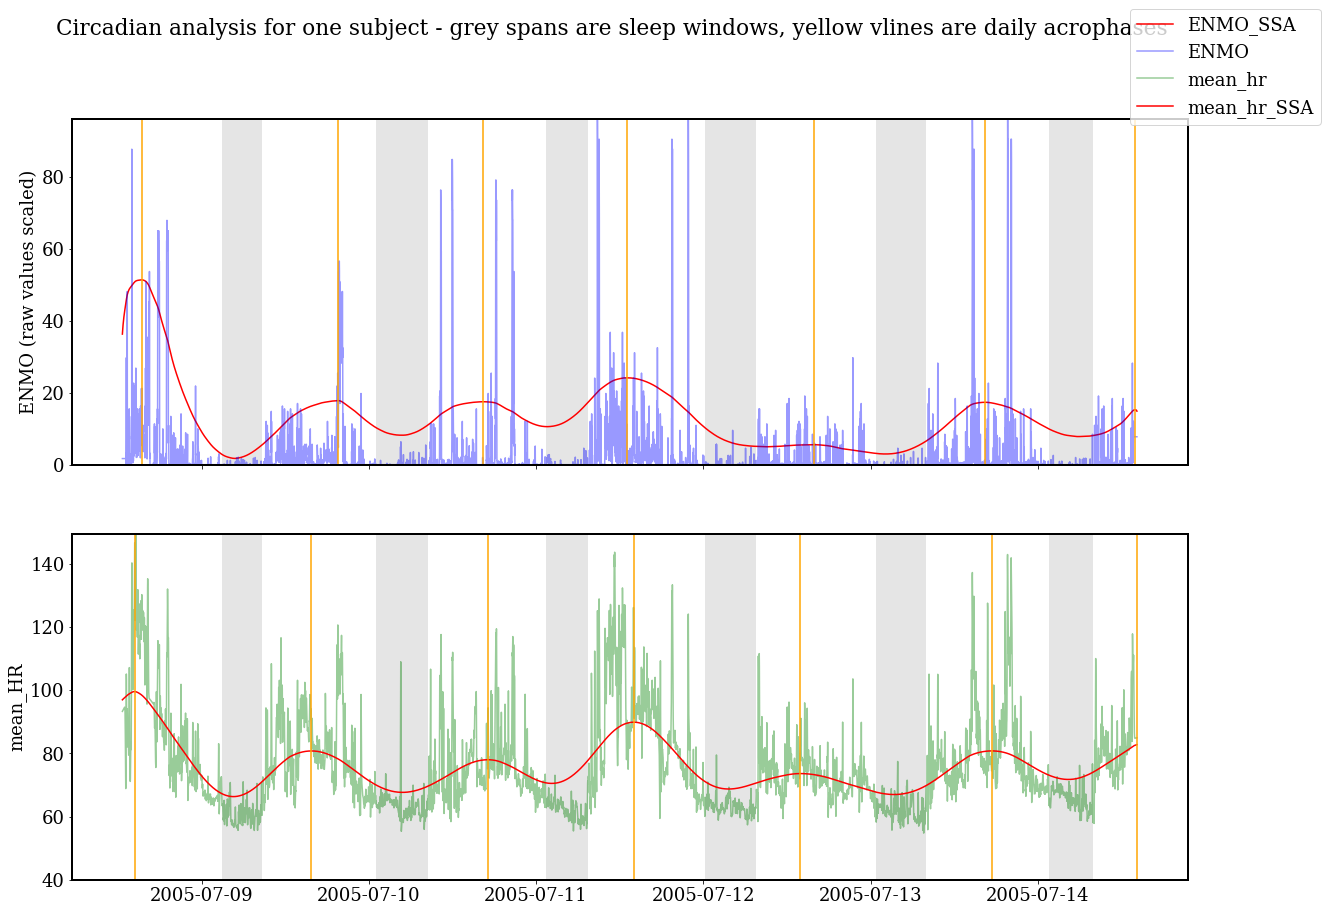

In [94]:
fig, ax1 = plt.subplots(2, 1, figsize= (20, 14),sharex=True)

ax1[0].plot(d[0].data.index,np.transpose(d[0].ssa['ENMO']['gk'])[0]+np.transpose(d[0].ssa['ENMO']['gk'])[1], color='red',label='ENMO_SSA')
ax1[0].plot(d[0].data.index, d[0].data['ENMO']/5,color='blue',alpha=0.4,label='ENMO')
ax1[0].set_ylim(0,max(d[0].data['ENMO']/5))
ax1[0].set_ylabel('ENMO (raw values scaled)')

for i in range(len(d[0].ssa['ENMO']['acrophase'])):
    ax1[0].axvline(x=d[0].ssa['ENMO']['acrophase'][i],color='orange')

ax1[1].plot(d[0].data.index, d[0].data['mean_hr'],color='green',alpha=0.4,label='mean_hr')
ax1[1].plot(d[0].data.index,np.transpose(d[0].ssa['mean_hr']['gk'])[0]+np.transpose(d[0].ssa['mean_hr']['gk'])[1],color='red',label='mean_hr_SSA')
ax1[1].set_ylim(40,max(d[0].data['mean_hr']))
ax1[1].set_ylabel('mean_HR')

for i in range(len(d[0].ssa['mean_hr']['acrophase'])):
    ax1[1].axvline(x=d[0].ssa['mean_hr']['acrophase'][i],color='orange')
    
for idx in range(2):
    for i in range(len(d[0].sleep_rec)):
        ax1[idx].axvspan(d[0].sleep_rec['sleep_onset'][i],d[0].sleep_rec['sleep_offset'][i],facecolor='grey',alpha=0.2)

fig.legend()
fig.suptitle('Circadian analysis for one subject - grey spans are sleep windows, yellow vlines are daily acrophases')
plt.show()

In [95]:
fig.savefig('Data/CircFig5.png')